In [1]:
import warnings
warnings.filterwarnings('ignore')
import os
from datetime import datetime

from matplotlib import pyplot as plt
import tensorflow as tf
import math
import keras
from keras.callbacks import TensorBoard
import numpy as np
import pandas as pd
from sklearn.utils import class_weight

In [2]:
file: str = os.getcwd() + '/Data/Preprocess Data Dummies.xlsx'
savePath: str = os.getcwd()

skiprows: int = 0
header: list = [0]
sheet_name: str = "Data"
groundtruth:str = 'Survived'
dropColumns: list = ['Cabin', 'Embarked', 'Ticket', 'First Name', 'Name', 'Log Fare Min Max',]

In [3]:
dataframe: pd.DataFrame = pd.read_excel(file, header=header, sheet_name=sheet_name, skiprows=skiprows)
dataframe = dataframe.set_index('PassengerId')

dataframe_submission: pd.DataFrame = pd.read_excel(file, header=header, sheet_name=sheet_name, skiprows=skiprows)
dataframe_submission = dataframe_submission.set_index('PassengerId')

dataframe.head(2)

Pclass_1  Pclass_2  Pclass_3  Cabin_A  Cabin_B  Cabin_C  Cabin_D  \
PassengerId                                                                     
259                 1         0         0        0        0        0        0   
680                 1         0         0        0        1        0        0   

             Cabin_E  Cabin_F  Cabin_G  ...  Parch_1  Parch_2  Parch_3  \
PassengerId                             ...                              
259                0        0        0  ...        0        0        0   
680                0        0        0  ...        1        0        0   

             Parch_4  Parch_5  Parch_6  Parch_9  Fare  Dataset  Survived  
PassengerId                                                               
259                0        0        0        0   1.0    train       1.0  
680                0        0        0        0   1.0    train       1.0  

[2 rows x 151 columns]

# Define train and test set

In [4]:
from sklearn.model_selection import train_test_split

In [5]:
dataframe_train: pd.DataFrame = dataframe[dataframe['Dataset'] == 'train']
dataframe_test: pd.DataFrame = dataframe[dataframe['Dataset'] == 'test']

In [6]:
# Train / Test definition
#x_train: pd.DataFrame = dataframe_train.drop(['Survived', 'Dataset'], axis=1, inplace=False)
x_train: pd.DataFrame = dataframe_train.copy(deep=True)
y_train: pd.DataFrame = dataframe_train['Survived']
    
x_test: pd.DataFrame = dataframe_test.copy(deep=True)

In [7]:
x_train, x_validation, y_train, y_validation = train_test_split(x_train,
                                                                y_train,
                                                                stratify=y_train,
                                                                test_size=0.2)

In [8]:
x_validation['Dataset'] = 'validation'
x_validation.head(1)

Pclass_1  Pclass_2  Pclass_3  Cabin_A  Cabin_B  Cabin_C  Cabin_D  \
PassengerId                                                                     
412                 0         0         1        0        0        0        0   

             Cabin_E  Cabin_F  Cabin_G  ...  Parch_1  Parch_2  Parch_3  \
PassengerId                             ...                              
412                0        0        0  ...        0        0        0   

             Parch_4  Parch_5  Parch_6  Parch_9      Fare     Dataset  \
PassengerId                                                             
412                0        0        0        0  0.013387  validation   

             Survived  
PassengerId            
412               0.0  

[1 rows x 151 columns]

In [9]:
dataframe = pd.concat([x_train.sort_index(ascending=True), 
                       x_validation.sort_index(ascending=True),
                       x_test.sort_index(ascending=True)], 
                      axis=0)

In [10]:
x_train: pd.DataFrame = x_train.drop(['Survived', 'Dataset'], axis=1, inplace=False)
x_validation: pd.DataFrame = x_validation.drop(['Survived', 'Dataset'], axis=1, inplace=False)
x_test: pd.DataFrame = x_test.drop(['Survived', 'Dataset'], axis=1, inplace=False)

# Training session

## Implement decay rate

In [11]:
def LearningRateDecay(initialLearningRate: float=0.0001, dropRate: float=0.5, epochsDrop: int=100, waitFor:int =100):
    def step_decay(epoch):
        if epoch >= waitFor:
            lrate: float = initialLearningRate * math.pow(dropRate, math.floor((1+epoch)/epochsDrop))
        else:
            lrate: float = initialLearningRate
        return lrate
    return step_decay

In [12]:
def LearningRateDecayTester(initialLearningRate: float=0.0001, dropRate: float=0.5, epochsDrop: int=100, epochNumber: int=100):
    # For linear decay use dropRate=0.999
    lrateDecay = list()
    for epoch in range(0, epochNumber):
        lrate = initialLearningRate * math.pow(dropRate, math.floor((1 + epoch) / epochsDrop))
        lrateDecay.append(lrate)
    return lrateDecay

## Multi Layer Perceptron

## Parameters

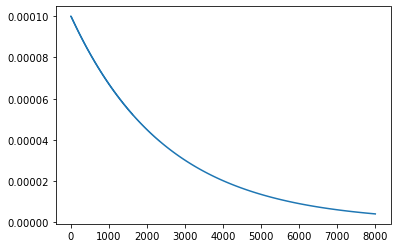

In [13]:
# Network Parameters
nbOutput:int = 1
Neurons: list = [x_train.shape[1],
                 x_train.shape[1],
                 x_train.shape[1] / 2,
                 x_train.shape[1] / 2,
                 x_train.shape[1] / 2,
                 x_train.shape[1] / 4]
    
input_shape: tuple = (x_train.shape[1], )
lastActivation: str = 'sigmoid'
dropout: float = 0.7
initializer: float = 0.1
learning_rate: float = 0.0001
batch_size: int = 32
epochs: int = 8000
    
dropRate: float = 0.998
epochsDrop: int = 5
    
weights = class_weight.compute_class_weight('balanced', np.unique(y_train), y_train)


plt.plot(LearningRateDecayTester(initialLearningRate=learning_rate,
                       dropRate=dropRate,
                       epochsDrop=epochsDrop,
                       epochNumber=epochs))

In [14]:
weights: dict = {0: weights[0], 1: weights[1]}
weights: dict = {0: 1., 1: 1.}
weights

{0: 1.0, 1: 1.0}

## Define model

In [15]:
from keras.models import Sequential
from keras.layers import Dense, Dropout, BatchNormalization, Activation, Softmax, Conv1D, MaxPool1D, Flatten, InputLayer, Reshape

def ConvNet(nbOutputs: int=1, Neurons=None, input_shape=(31,1), lastActivation='sigmoid', dropout: float=0.4):
        
        kernel_initializer = keras.initializers.RandomNormal(mean=0., stddev=1.)       
        bias_initializer = keras.initializers.Constant(0.1)
        
        model = Sequential()
        model.add(Reshape((input_shape[0], 1), input_shape=(input_shape[0], 1)))
        model.add(Conv1D(input_shape=(input_shape[0], 1), 
                         filters=16, 
                         kernel_size=3, 
                         strides=1))
        model.add(Flatten())
        
        model.add(Dense(np.ceil(model.output_shape[1:][0]).astype(int)))
        model.add(Activation('relu'))
        model.add(BatchNormalization())
        model.add(Dropout(dropout))

        model.add(Dense(units=Neurons[0], 
                        kernel_initializer=kernel_initializer, 
                        bias_initializer=kernel_initializer))
        model.add(Activation('relu'))
        model.add(BatchNormalization())
        model.add(Dropout(dropout))

        for n in range(1, len(Neurons)):
            model.add(Dense(Neurons[n], 
                            kernel_initializer=kernel_initializer, 
                            bias_initializer=kernel_initializer))
            model.add(Activation('relu'))
            model.add(BatchNormalization())

            if dropout != 0:
                model.add(Dropout(dropout))

        model.add(Dense(nbOutputs, 
                        activation=lastActivation, 
                        kernel_initializer=kernel_initializer, 
                        bias_initializer=kernel_initializer))
        
        return model

In [16]:
def MLP(nbOutputs: int=1, Neurons=None, input_shape=(31,), lastActivation='sigmoid', dropout: float=0.4):

    model = Sequential()
    model.add(InputLayer(input_shape=input_shape, name="input"))
    
    model.add(Dense(units=Neurons[0],
                    name='h0'))
    
    model.add(Activation('relu'))
    model.add(BatchNormalization())
    model.add(Dropout(dropout))

    for n in range(1, len(Neurons)):
        model.add(Dense(Neurons[n],
                        name='h{}'.format(n)))
        model.add(Activation('relu'))
        model.add(BatchNormalization())
        model.add(Dropout(dropout))

    model.add(Dense(nbOutputs, 
                    activation=lastActivation,
                    name='o'))

    return model

def CNN(nbOutputs: int=1, Neurons=None, input_shape=(31,1), lastActivation='sigmoid', dropout: float=0.4):
        kernel_initializer = keras.initializers.RandomNormal(mean=0., stddev=1.)       
        bias_initializer = keras.initializers.Constant(0.1)
        
        model = Sequential()
        model.add(Reshape((input_shape[0], 1), input_shape=(input_shape[0], 1)))
        model.add(Conv1D(input_shape=(input_shape[0], 1), 
                         filters=16, 
                         kernel_size=3, 
                         strides=1))
        model.add(Activation('relu'))

        model.add(Conv1D(filters=16, 
                         kernel_size=3,
                         strides=1))
        model.add(Activation('relu'))

        model.add(Flatten())

        model.add(Dense(np.ceil(model.output_shape[1:][0]).astype(int),
                        kernel_initializer=kernel_initializer, 
                        bias_initializer=bias_initializer))
        model.add(Activation('relu'))
        model.add(BatchNormalization())
        model.add(Dropout(dropout))
        
        model.add(Dense(1024, 
                        kernel_initializer=kernel_initializer, 
                        bias_initializer=bias_initializer))
        model.add(Activation('relu'))
        model.add(BatchNormalization())
        model.add(Dropout(dropout))
        
        model.add(Dense(1024, 
                        kernel_initializer=kernel_initializer, 
                        bias_initializer=bias_initializer))
        model.add(Activation('relu'))
        model.add(BatchNormalization())
        model.add(Dropout(dropout))
                
        model.add(Dense(nbOutputs, activation=lastActivation))

        return model

In [17]:
model_mlp = MLP(nbOutputs=nbOutput,
              Neurons=Neurons,
              input_shape=input_shape,
              lastActivation=lastActivation,
              dropout=dropout)

print(model_mlp.summary())

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
h0 (Dense)                   (None, 149)               22350     
_________________________________________________________________
activation (Activation)      (None, 149)               0         
_________________________________________________________________
batch_normalization (BatchNo (None, 149)               596       
_________________________________________________________________
dropout (Dropout)            (None, 149)               0         
_________________________________________________________________
h1 (Dense)                   (None, 149)               22350     
_________________________________________________________________
activation_1 (Activation)    (None, 149)               0         
_________________________________________________________________
batch_normalization_1 (Batch (None, 149)               5

model_convnet = ConvNet(nbOutputs=nbOutput,
              Neurons=Neurons,
              input_shape=(input_shape[0], 1),
              lastActivation=lastActivation,
              dropout=dropout)

#print(model_convnet.summary())

model_cnn = CNN(nbOutputs=nbOutput,
              input_shape=(input_shape[0], 1),
              lastActivation=lastActivation,
              dropout=dropout)

#print(model_cnn.summary())

In [18]:
opt = keras.optimizers.SGD(learning_rate=learning_rate,
                           nesterov=True,
                           momentum=0.2)

model_mlp.compile(optimizer=opt, loss='binary_crossentropy', metrics=["binary_accuracy"])

## Save model

In [19]:
modelPath = os.path.join(os.getcwd(), "MLP Test", str(datetime.now()).replace(":", "-").replace(".", "-"))
os.makedirs(modelPath)

In [20]:
with pd.ExcelWriter(os.path.join(modelPath, 'Preprocess Data Dummies.xlsx'), mode='rw') as writer:  
    dataframe.to_excel(writer, sheet_name='Data')

## Callbacks

In [21]:
import TensorBoardCallback

In [22]:
import importlib
importlib.reload(TensorBoardCallback)

<module 'TensorBoardCallback' from 'C:\\Work\\Projets\\Titanic\\TensorBoardCallback.py'>

In [23]:
tensorboard = TensorBoardCallback.TensorBoardCallback(saving_path=modelPath,
                                                      x_train=x_validation,
                                                      y_true=y_validation)

Callback initialized
logs dir: C:\Work\Projets\Titanic\MLP Test\2021-03-21 00-17-12-842213\logs
models dir: C:\Work\Projets\Titanic\MLP Test\2021-03-21 00-17-12-842213\model


In [24]:
LRScheduler = keras.callbacks.LearningRateScheduler(LearningRateDecay(initialLearningRate=learning_rate, dropRate=dropRate, epochsDrop=epochsDrop))

In [25]:
callbacks = [tensorboard, tensorboard.tensorboard]

In [26]:
model_mlp.fit(x_train, y_train,
          epochs=epochs,
          callbacks=callbacks,
          verbose=0,
          class_weight=weights,
          batch_size=batch_size,
          validation_data=(x_validation, y_validation))

KeyboardInterrupt: 

<Figure size 480x480 with 0 Axes>